In [1]:
import os
os.environ['DYLD_FALLBACK_LIBRARY_PATH'] = '/opt/homebrew/lib'
import openslide
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
import json
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
annotation_path = "/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/STAT7007 Deep leanring/Project/images/BRACS_1494.geojson"
wsi_path = "/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/STAT7007 Deep leanring/Project/images/BRACS_1494.svs"
slide = openslide.OpenSlide(wsi_path)
with open(annotation_path, 'r') as file:
    annotations = json.load(file)

def extract_polygons(geojson):
    polygons = []
    for feature in geojson:
        if feature['properties']['classification']['name'] == 'UDH-sure':
            polygons.append(feature['geometry']['coordinates'])
    return polygons
polygons = extract_polygons(annotations)

In [3]:
from tqdm import tqdm
def generate_mask(slide, polygons):
    level = 0  # set resolution level
    downsample = slide.level_downsamples[level]
    dims = slide.level_dimensions[level]
    mask = Image.new('L', dims, 0)
    draw = ImageDraw.Draw(mask)
    for polygon in polygons:
        scaled_polygon = [(x / downsample, y / downsample) for x, y in polygon[0]]
        draw.polygon(scaled_polygon, outline=1, fill=1)

    return mask

def tile_mask(mask, tile_size):
    width, height = mask.size
    tiles = []
    for y in tqdm(range(0, height, tile_size)):  # y first as rows
        for x in range(0, width, tile_size):  # x next as columns
            # Adjust box to handle edge cases
            box = (x, y, min(x + tile_size, width), min(y + tile_size, height))
            tile = mask.crop(box)
            # Optionally pad the tile if it's smaller than tile_size
            if tile.size[0] != tile_size or tile.size[1] != tile_size:
                tile = ImageOps.pad(tile, (tile_size, tile_size))
            tiles.append(tile)
    return tiles

def tile_wsi(slide, tile_size, level=0):
    tiles = []
    slide_width, slide_height = slide.level_dimensions[level]
    for y in tqdm(range(0, slide_height, tile_size)):
        for x in range(0, slide_width, tile_size):
            box = (x, y, min(x + tile_size, slide_width), min(y + tile_size, slide_height))
            tile = slide.read_region(box[:2], level, (box[2] - box[0], box[3] - box[1]))
            if tile.size[0] != tile_size or tile.size[1] != tile_size:
                tile = ImageOps.pad(tile.convert('RGBA'), (tile_size, tile_size))
            tile = tile.convert('RGB')  # Convert from RGBA to RGB
            tiles.append(tile)
    return tiles

In [5]:
print("Tile Wsi")
tiles = tile_wsi(slide, 512)

Tile Wsi


100%|██████████| 166/166 [02:47<00:00,  1.01s/it]


In [10]:
new_path = '/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/STAT7007 Deep leanring/Project/DL/tiles_grayscale'
# Loop over all tiles, converting and saving each one
for index, image in enumerate(tqdm(tiles)):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)  # Convert from PIL Image to NumPy array then to grayscale

    # Generate a unique filename for each grayscale image
    filename = f'gray_tile_{index}.png'

    # Save the grayscale image to the new path
    cv2.imwrite(os.path.join(new_path, filename), gray_image)

print("Conversion to grayscale completed!")

100%|██████████| 32370/32370 [03:12<00:00, 168.55it/s]

Conversion to grayscale completed!


: 

In [ ]:
print("Tile Mask")
mask = generate_mask(slide, polygons, 512)  # Full-size mask
masks = tile_mask(mask, 512)  # List of masks

In [8]:
# os.makedirs('/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/STAT7007 Deep leanring/Project/DL/tile_images', exist_ok=True)
# for i, tile in enumerate(tiles):
#     tile.save(os.path.join('/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/STAT7007 Deep leanring/Project/DL/tile_images', f'tile_{i}.png'))

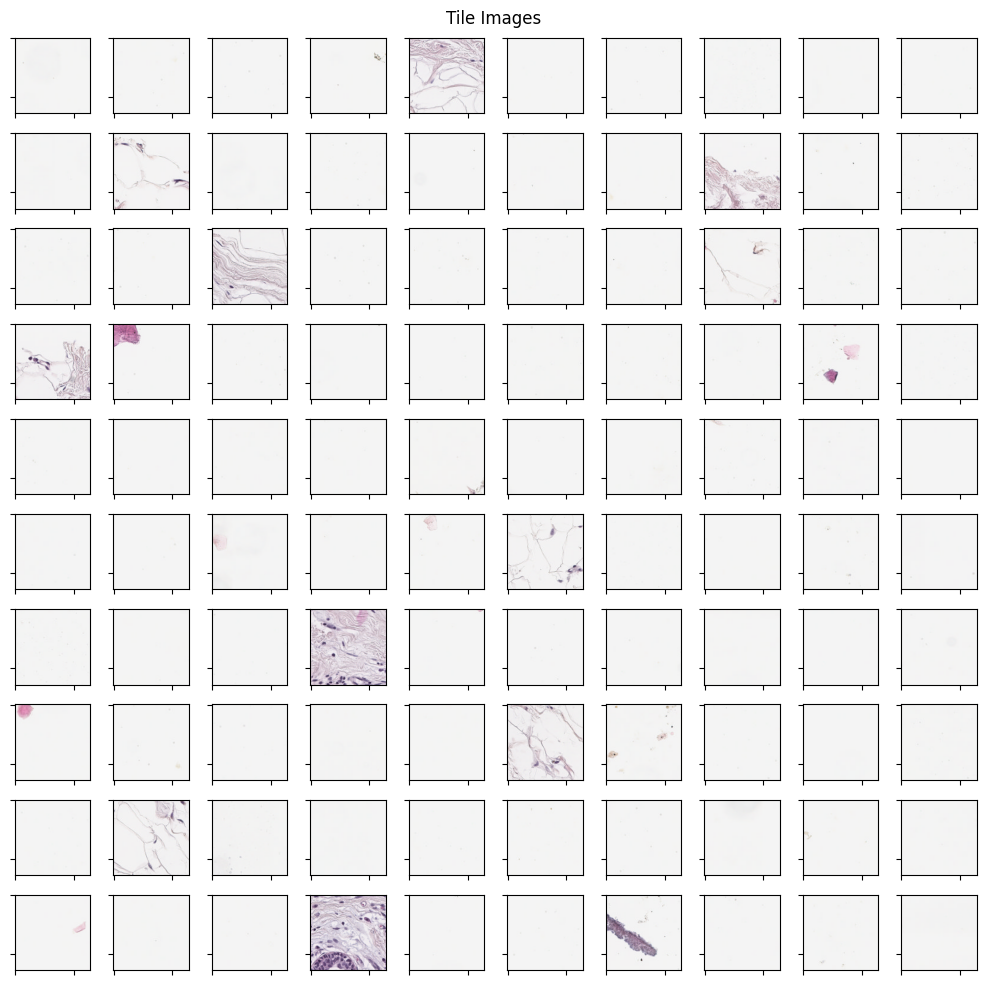

In [52]:
tile_list = []
for i in tiles:
    tile_list.append(i)
nb_rows = 10
nb_cols = 10
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10,10))
plt.suptitle('Tile Images')
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        axs[i, j].imshow((tile_list[np.random.randint(len(tile_list))]))
plt.tight_layout()
plt.show()

In [69]:
class UNet(nn.Module):
    """
    Base Unet Implementation
    """

    def __init__(self, n_class:int = 2) -> None:
        """
        Initialize Unet, n_class is number of classes we want to segment images for
        Defaults at 2 for 2 ROI types
        """
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image. 
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [70]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TiledWSIDataset(Dataset):
    def __init__(self, tiles, masks):
        self.tiles = tiles
        self.masks = masks
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        image = self.transform(self.tiles[idx], dtype=np.int64)
        mask = torch.tensor(np.array(self.masks[idx]), dtype=torch.long)
        return image, mask

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        image = self.transform(self.tiles[idx])
        mask = self.masks[idx]
        mask = np.array(mask)
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

dataset = TiledWSIDataset(tiles, masks)
data_loder = DataLoader(dataset, batch_size=4, shuffle=True)

In [73]:
from torch.optim import Adam

def dice_loss(pred, target):
    smooth = 1.
    pred = pred.sigmoid()  # Ensure pred is in [0,1] if using a single channel output
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

def criterion(pred, target):
    # Squeeze the channel dimension in pred if it's 1 (BCE expects no channel dimension for 2D)
    
    pred = pred.squeeze(1)
    # Calculate BCE Loss
    bce_loss = F.binary_cross_entropy_with_logits(pred, target.float(), reduction='mean')
    
    # Calculate Dice Loss
    dice = dice_loss(pred, target)
    
    return dice + bce_loss


model = UNet(n_class=1)
optimizer = Adam(model.parameters(), lr=0.0001)

In [74]:
from tqdm import tqdm
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
def train(model, dataloader, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader.dataset)}')

# Train the model
train(model, train_loader, criterion, optimizer, epochs=3)


100%|██████████| 1601/1601 [2:38:50<00:00,  5.95s/it] 


Epoch 1, Loss: 7004.298912779268


  3%|▎         | 42/1601 [04:14<2:37:08,  6.05s/it]


KeyboardInterrupt: 

In [42]:
from torch import no_grad
from sklearn.metrics import jaccard_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_iou, total_dice = 0, 0
    total_samples = 0
    
    with no_grad():  # Disable gradient computation
        for images, true_masks in dataloader:
            predictions = model(images)
            predictions = torch.sigmoid(predictions)  # Apply sigmoid to get [0,1] range
            predictions = (predictions > 0.5).float()  # Threshold predictions to get binary mask

            # Flatten the masks and predictions to compute IoU and Dice Scores
            pred_flat = predictions.view(-1)
            true_flat = true_masks.view(-1)
            
            # Calculate Intersection over Union (IoU) and Dice Score
            iou = jaccard_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy())
            dice = f1_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy())

            total_iou += iou
            total_dice += dice
            total_samples += 1

    # Average over all batches
    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples
    
    return avg_iou, avg_dice


In [ ]:
# Assume test_loader is already defined
average_iou, average_dice = evaluate_model(model, test_loader)
print(f'Average IoU: {average_iou:.4f}, Average Dice Score: {average_dice:.4f}')

In [43]:
import matplotlib.pyplot as plt
import torch
from torch import no_grad

def evaluate_and_print_predictions(model, dataloader, num_images_to_print=5):
    model.eval()  # Set the model to evaluation mode
    images_shown = 0
    
    with no_grad():  # Disable gradient computation
        for images, true_masks in dataloader:
            if images_shown >= num_images_to_print:
                break

            predictions = model(images)
            predictions = torch.sigmoid(predictions)  # Apply sigmoid to get [0,1] range
            predicted_masks = (predictions > 0.5).float()  # Threshold predictions to get binary mask

            for i in range(min(num_images_to_print - images_shown, images.size(0))):
                plt.figure(figsize=(12, 6))
                
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")
                plt.axis("off")
                
                plt.subplot(1, 3, 2)
                plt.imshow(true_masks[i].cpu(), cmap='gray')
                plt.title("Actual Mask")
                plt.axis("off")
                
                plt.subplot(1, 3, 3)
                plt.imshow(predicted_masks[i][0].cpu(), cmap='gray')  # Assume single channel output
                plt.title("Predicted Mask")
                plt.axis("off")
                
                plt.show()
                
            images_shown += images.size(0)


In [ ]:
evaluate_and_print_predictions(model, test_loader, num_images_to_print=5)